In [1]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(
    "https://gml.noaa.gov/grad/solcalc/NOAA_Solar_Calculations_year.xls",
    parse_dates=["Date"],
    skiprows=[366],
)

In [3]:
def unix2date(unix):
    dote = unix / 86400 + 719468
    cykl = (
        dote if dote >= 0
        else dote - 146096
    ) // 146097
    dotc = dote - cykl * 146097
    yotc = (dotc
        - dotc // 1460
        + dotc // 36524
        - dotc // 146096
    ) // 365
    return [
        int(yotc + cykl * 400),
        int(dotc - (yotc * 365
            + yotc // 4
            - yotc // 100))
    ]

In [4]:
df = pd.concat([
    df,
    pd.DataFrame(
        [unix2date(d.timestamp()) for d in df["Date"]],
        columns=["year", "doy"],
    ),
], axis=1).sort_values("doy").reset_index()

In [5]:
df["original"] = df["Eq of Time (minutes)"] / 144 

In [6]:
df["radians"] = math.tau * df.index / 365

In [7]:
def model(gamma, p0, p1, p2, p3, p4):
    return (
        p0 +
        p1 * np.cos(gamma) +
        p2 * np.sin(gamma) +
        p3 * np.cos(2 * gamma) +
        p4 * np.sin(2 * gamma)
    )

In [8]:
#| label: eot
popt, pcov = curve_fit(model, df["radians"], df["original"])
dict(enumerate(popt.tolist()))

{0: 1.4950424467725955e-05,
 1: -0.04189873301524992,
 2: -0.02923703633324393,
 3: -0.0456943801628261,
 4: 0.05175601752530743}

In [9]:
df["fitted"] = [model(r, *popt) for r in df["radians"]]

In [10]:
plotopts = {"linewidth": 3, "legend": True}

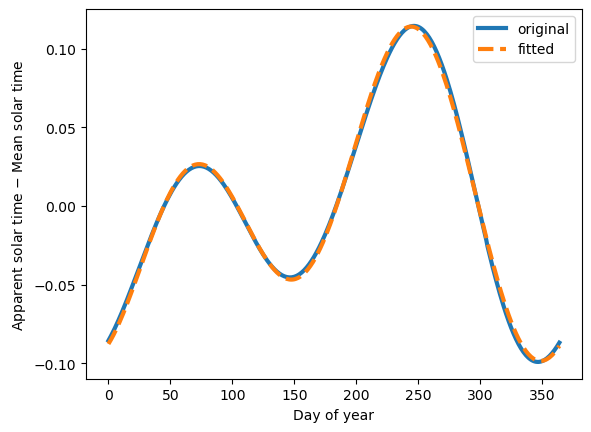

In [11]:
df["original"].plot(
    xlabel="Day of year",
    ylabel=r"Apparent solar time $-$ Mean solar time",
    **plotopts
)
df["fitted"].plot(linestyle="--", **plotopts);

In [12]:
df["original"] = df["Sun Declin (deg)"] * np.pi / 180

In [13]:
#| label: sda
popt, pcov = curve_fit(model, df["radians"], df["original"])
dict(enumerate(popt.tolist()))

{0: 0.006878449305004424,
 1: -0.14278002226634132,
 2: 0.3799303998359597,
 3: 0.0039588461763330925,
 4: 0.005561843926537278}

In [14]:
df["fitted"] = [model(r, *popt) for r in df["radians"]]

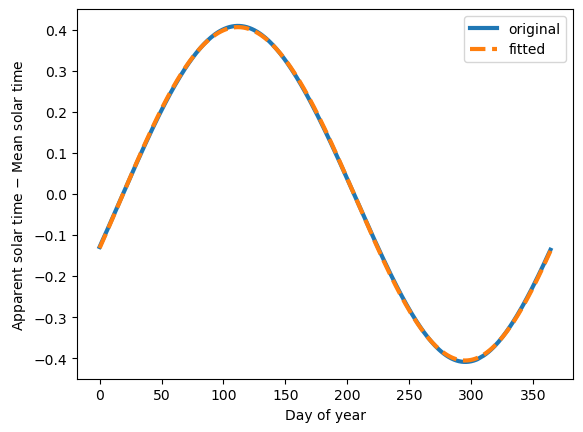

In [15]:
df["original"].plot(
    xlabel="Day of year",
    ylabel=r"Apparent solar time $-$ Mean solar time",
    **plotopts
)
df["fitted"].plot(linestyle="--", **plotopts);

In [16]:
sza = 90.833 * np.pi / 180

In [17]:
sza

1.5853349194640092